In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'DIA'  # emerging markets
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_dow.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%***********************]  1 of 1 completed
Generating derived columns...
(6742, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1998-01-20,77.81250,78.843750,77.406250,78.812500,44.534756,3.796270,1.012851,0.987707,0.990880
1998-01-21,78.09375,78.375000,77.281250,77.843750,43.987286,3.783901,0.996799,0.991570,0.991570
1998-01-22,77.18750,77.859375,76.937500,77.187500,43.616482,3.775435,1.000000,0.997571,1.004049
1998-01-23,77.50000,77.750000,76.312500,77.000000,43.510521,3.773003,0.993548,1.004059,1.004870
1998-01-26,77.37500,77.671875,76.937500,77.312500,43.687119,3.777053,0.999192,1.011722,0.997575
1998-01-27,77.12500,78.562500,77.078125,78.218750,44.199203,3.788707,1.014182,1.011586,1.001998
1998-01-28,78.37500,79.234375,78.218750,79.125000,44.711292,3.800226,1.009569,1.003555,0.999210
1998-01-29,79.06250,80.250000,78.890625,79.406250,44.870232,3.803775,1.004348,0.997836,1.006690
1998-01-30,79.93750,79.937500,78.968750,79.234375,44.773129,3.801608,0.991204,1.022480,1.017551


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
1998-01-20     78.843750
1998-01-21     78.375000
1998-01-22     77.859375
1998-01-23     77.750000
1998-01-26     77.671875
                 ...    
2024-10-28    424.820007
2024-10-29    424.970001
2024-10-30    424.649994
2024-10-31    419.929993
2024-11-01    423.299988
Name: high, Length: 6742, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2009-01-02')  # first day of legit open/close values
SIM_START

Timestamp('2009-01-02 00:00:00')

In [7]:
len(df.index >= SIM_START)

6742

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear']), #'linear_ma']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

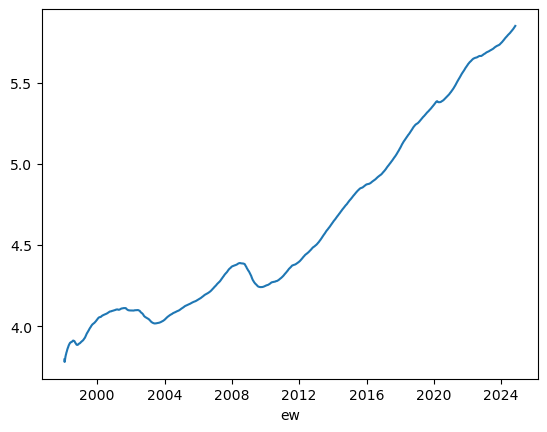

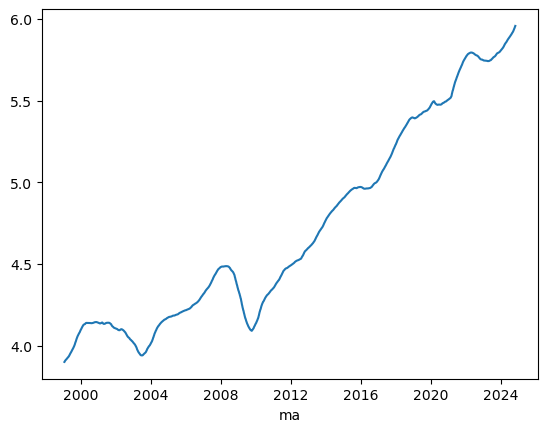

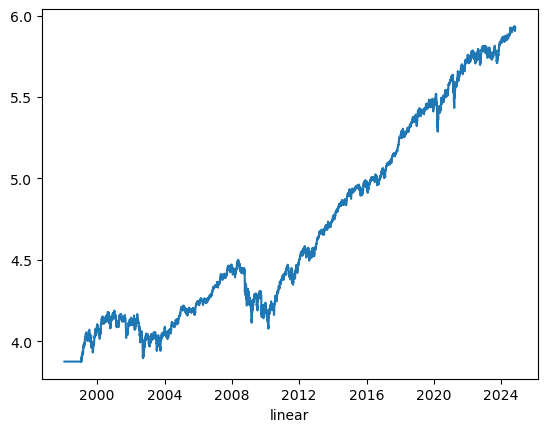

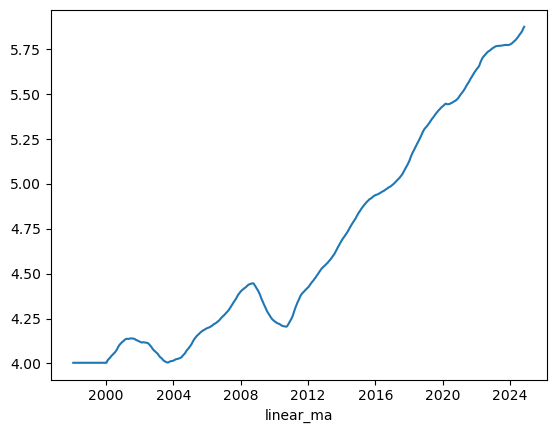

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params# = None, None

(None, None)

Do nothing res: 6.67312505010418
Round 1: 1.1139587997011238
New best: 1.1139587997011238
{'time_param': 169, 'method': 'linear', 't': 0.08468513946105416, 'k': 0.1076163228121546, 'as_q': False, 'transform_f': 'bounded_curve'}


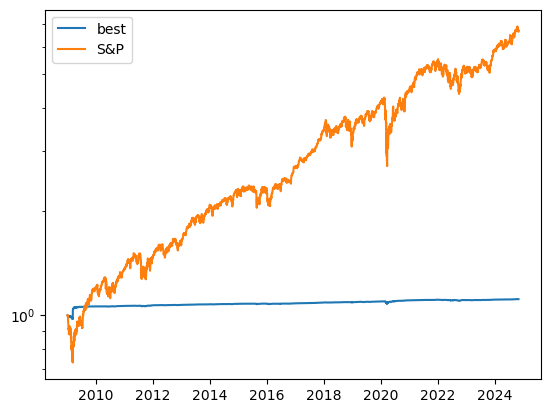

Round 2: 7.577990772228324
New best: 7.577990772228324
{'time_param': 187, 'method': 'ew', 't': 0.12165149495314742, 'k': 5.301827848975923, 'as_q': True, 'transform_f': 'bounded_curve'}


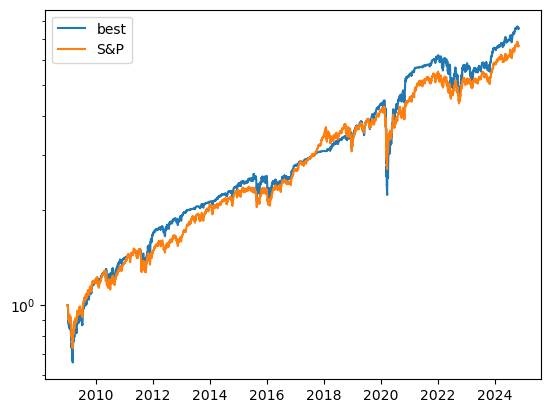

Round 3: 4.800846581540174
Round 4: 1.2401565862619273
Round 5: 13.663545619575821
New best: 13.663545619575821
{'time_param': 233, 'method': 'linear', 't': 0.38579138959450576, 'k': 9.879842869964339, 'as_q': False, 'transform_f': 'bounded_curve'}


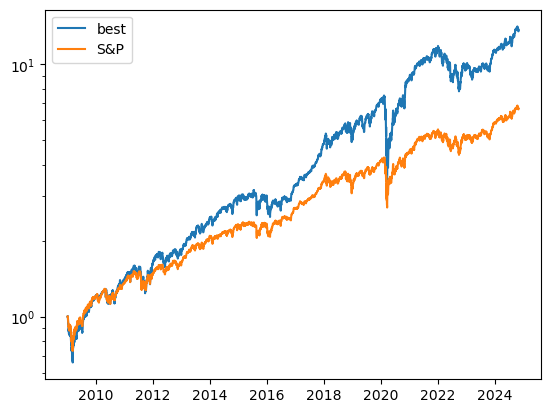

Round 6: 1.08550388419301
Round 7: 1.0713169987640303
Round 8: 15.652127366837021
New best: 15.652127366837021
{'time_param': 133, 'method': 'ew', 't': 0.8438412883776677, 'k': 2.9523387654435083, 'as_q': True, 'transform_f': 'bounded_curve'}


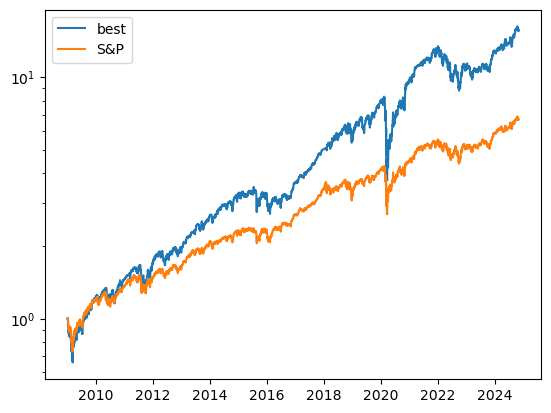

Round 9: 1.1284540877438074
Round 10: 4.02448197093656
Round 11: 9.678964800308286
Round 12: 2.2736093302771088
Round 13: 8.37888062643274
Round 14: 4.923532484856553
Round 15: 5.577842770747695
Round 16: 1.2003933358490495
Round 17: 1.0374002360641172
Round 18: 3.971962111058807
Round 19: 3.3563791652425246
Round 20: 1.5240042716067108
Round 21: 1.073445491988845
Round 22: 1.3202815888324395
Round 23: 3.770964095674649
Round 24: 6.487831273831524
Round 25: 1.1764778460098013
Round 26: 4.107271780759519
Round 27: 15.330476662008017
Round 28: 9.964474283398651
Round 29: 2.486550525471337
Round 30: 1.924760101964302
Round 31: 1.3205686646227128
Round 32: 6.512086565466725
Round 33: 15.420011937488528
Round 34: 2.4339683419199587
Round 35: 17.735974420730674
New best: 17.735974420730674
{'time_param': 6, 'method': 'ew', 't': 0.8529968467381195, 'k': 4.497778991521695, 'as_q': True, 'transform_f': 'bounded_curve'}


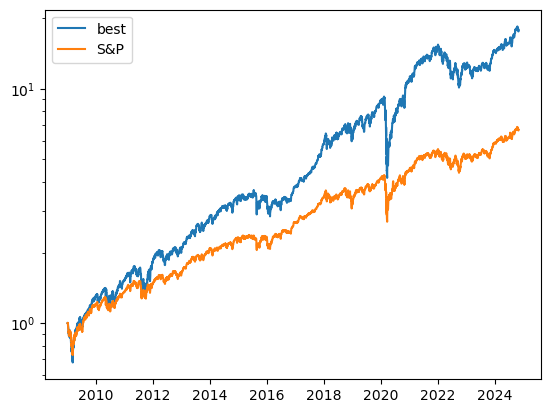

Round 36: 1.026617608244681
Round 37: 4.789904062386103
Round 38: 1.5512671003759584
Round 39: 1.1109907028237846
Round 40: 1.0653186076444396
Round 41: 1.5996014613344633
Round 42: 2.8190442234720168
Round 43: 15.030815086014659
Round 44: 15.056729836939232
Round 45: 1.5876406480779301
Round 46: 8.822533484892144
Round 47: 3.0212931067241025
Round 48: 4.183146265454364
Round 49: 7.089655776381215
Round 50: 5.570717548651139
Round 51: 3.9253949406287045
Round 52: 3.289363021534289
Round 53: 4.078162996067889
Round 54: 1.2016460596672045
Round 55: 8.413153360400315
Round 56: 7.352397324774243
Round 57: 1.1304889573687436
Round 58: 10.837825670763088
Round 59: 18.955413051292492
New best: 18.955413051292492
{'time_param': 41, 'method': 'ma', 't': 0.9702133582659588, 'k': 8.969400566299376, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


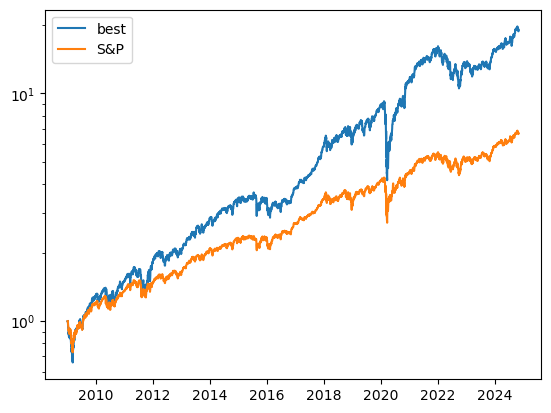

Round 60: 1.2488956481864337
Round 61: 3.59040515476834
Round 62: 12.39793598166603
Round 63: 3.5862496390370238
Round 64: 5.596295346093747
Round 65: 11.558823724153516
Round 66: 2.8795962262266093
Round 67: 1.1821546446002502
Round 68: 2.923309892744699
Round 69: 5.834090596637023
Round 70: 3.1500962415933094
Round 71: 5.032400084922734
Round 72: 1.4122611850969304
Round 73: 14.974578375394314
Round 74: 12.39240506333011
Round 75: 1.4324196919355885
Round 76: 2.1065184182496806
Round 77: 2.34294760639447
Round 78: 3.307968789721496
Round 79: 15.594306030059705
Round 80: 5.570114737349721
Round 81: 7.563012353093164
Round 82: 3.568149134418068
Round 83: 14.377645255129101
Round 84: 3.4101921802669715
Round 85: 15.424836884098697
Round 86: 11.809351812834743
Round 87: 1.6199519658837789
Round 88: 7.51901784006046
Round 89: 3.956749651464695
Round 90: 6.99545015204664
Round 91: 4.78724328440086
Round 92: 1.0257566425420375
Round 93: 1.0601080956197801
Round 94: 1.0884941859343396
Round 

In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 6.67312505010418
Round 1: 16.23053493978632
Round 2: 16.247302118908067
Round 3: 21.901066863745076
New best: 21.901066863745076
{'time_param': 41, 'method': 'ma', 't': 0.9367211298244255, 'k': 9.300056977774423, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


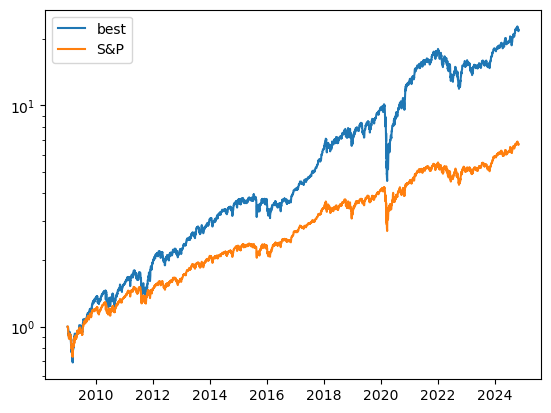

Round 4: 19.550569270577714
Round 5: 6.1636157468471495
Round 6: 16.227469503369118
Round 7: 20.815074222047656
Round 8: 14.389782853576397
Round 9: 6.759018893735854
Round 10: 7.532090302578892

Factor: 1.03125
Do nothing res: 6.67312505010418
Round 1: 20.75322547269078
Round 2: 18.054694192177102
Round 3: 16.450538736158293
Round 4: 16.443665997423142
Round 5: 6.029603135414481
Round 6: 5.581858098218734
Round 7: 21.373397461190418
Round 8: 16.23250749872136
Round 9: 6.7494356162629945
Round 10: 16.03712122817592

Factor: 1.015625
Do nothing res: 6.67312505010418
Round 1: 16.03748213172014
Round 2: 16.03662847106247
Round 3: 16.037996369602162
Round 4: 5.775344811731998
Round 5: 6.401792598770473
Round 6: 16.03799400528091
Round 7: 21.51669664364175
Round 8: 21.510177427871497
Round 9: 5.872316020008088
Round 10: 16.038056821706686

Factor: 1.0078125
Do nothing res: 6.67312505010418
Round 1: 16.037508085484163
Round 2: 16.03741355927397
Round 3: 16.037027665610438
Round 4: 3.80343878

In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=10, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [20]:
# Force set:
#best_out = 33.55436395490332
#params_out = {'time_param': 153, 'method': 'ew', 't': 0.9977578507998721, 'k': 0.1502092583872895, 'as_q': True, 'transform_f': 'bounded_sigmoid'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

1.0

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.3393523354723175

In [24]:
params_out

{'time_param': 41,
 'method': 'ma',
 't': 0.9367211298244255,
 'k': 9.300056977774423,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/dsp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


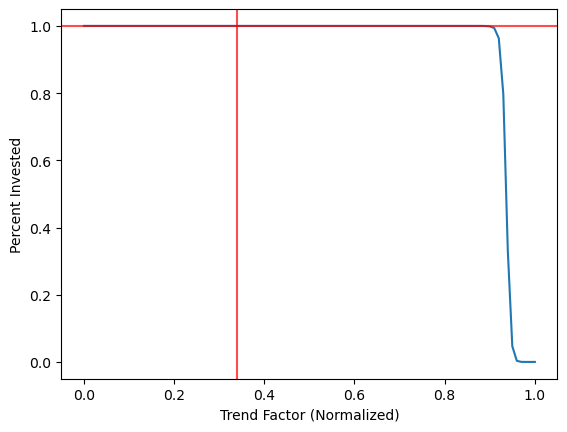

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

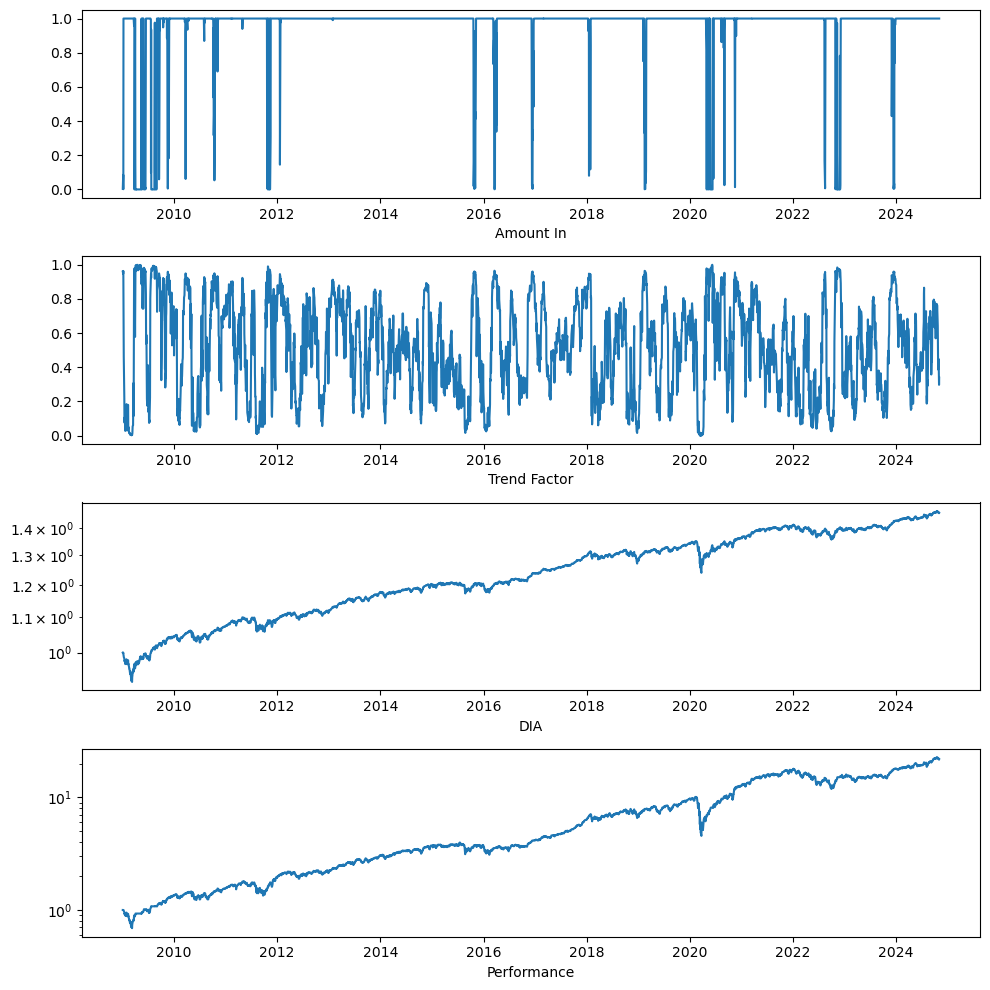

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('DIA')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('DIA')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

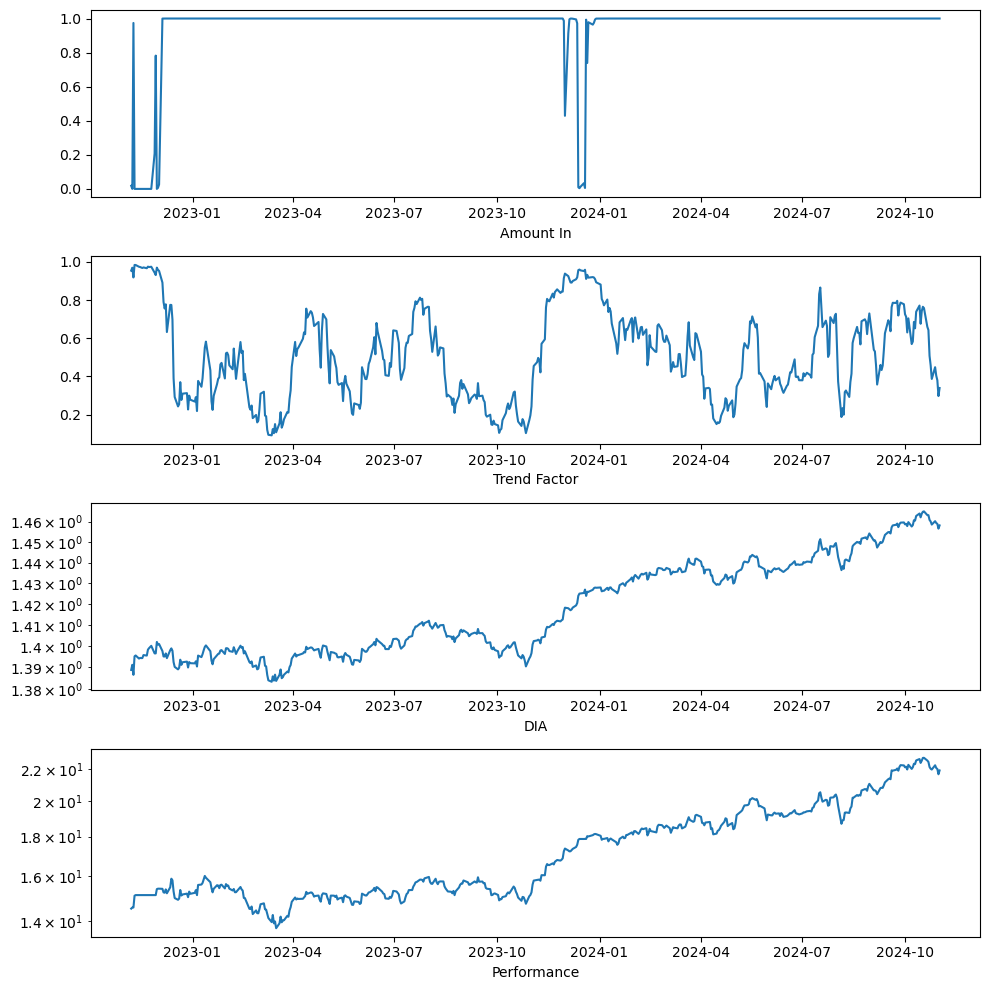

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('DIA')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

1.0

In [30]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(63.00196838378906, 15.944, 420.4200134277344)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.2135937638282468

In [32]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['dia'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1195809596024326, 1.0], 'nas': [1.2400991798626717, 1.0], 'rus': [1.289635015313776, 1.0], 'jpxn': [1.0738414738575615, 0.9804], 'ktec': [1.6302079070835445, 0.0], 'emb': [1.075625264258124, 1.0], 'gdx': [1.3583771630868045, 0.1098], 'dia': [1.2135937638282468, 1.0], 'nfty': [1.2330869591330673, 1.0]}


In [33]:
stop

NameError: name 'stop' is not defined

In [34]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(21.901066863745076,
 {'time_param': 41,
  'method': 'ma',
  't': 0.9367211298244255,
  'k': 9.300056977774423,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})